## 导入包

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np
import pandas as pd
import torchvision
from torch.utils.data import DataLoader
from datetime import datetime  # 用于计算时间

import os
import sys
from collections import Counter
import re

#import tensorflow.contrib.keras as kr
from torch.nn.utils.rnn import pack_padded_sequence
from torch.nn.utils.rnn import pad_packed_sequence

#from torchtext import data
import jieba

#import cv2
import os

from torch.autograd import Variable
#import tensorwatch as tw
import torchvision.models

from pathlib import Path
import pandas as pd

import matplotlib.pyplot as plt
torch.set_printoptions(precision=15)
pd.set_option('display.max_rows',None)
pd.set_option('display.max_columns',None)
np.set_printoptions(threshold=np.inf)

import time
import random

from torch.autograd import Variable
from torch.autograd import Function

import seaborn as sns
# seaborn中文乱码解决方案
from matplotlib.font_manager import FontProperties

from tensorboardX import SummaryWriter
import torch.backends.cudnn as cudnn

## 路径

In [66]:
vocab_dir = './data/vocab.txt'
train_path = './data/training/training.txt'
val_path = './data/validation/validation.txt'
csv_path = './data/csv'
test_path = './data/test/test.txt'
run_path = './runs/'
save_the_first_model_path = './data/save/save_model/' 

## GPU

In [3]:
#验证gpu是否有效
print(torch.cuda.is_available())
if torch.cuda.is_available():
    gpu_id = 0
    torch.cuda.set_device(gpu_id)

True


In [4]:
#固定随机数种子
seed = 0
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
random.seed(seed)

## 功能函数

In [5]:
def write_resualt_file(path, line):
    with open(path, 'a') as f:
        f.write(line+'\n')

In [6]:
def draw(train_loss_list, val_loss_list):
    x1 = range(0, len(train_loss_list))
    x2 = range(0, len(val_loss_list))
    #with plt.style.context(['science']):
    plt.subplot(2, 1, 1)
    plt.plot(x1, train_loss_list[:len(train_loss_list)], 'o-')
    plt.title('train loss vs. epoches')
    plt.ylabel('train loss')
    plt.subplot(2, 1, 2)
    plt.plot(x2,val_loss_list[:len(val_loss_list)] , '.-')
    plt.xlabel('Val loss vs. epoches')
    plt.ylabel('Val loss')
    plt.show()

In [7]:
def draw_data(data_list):
    '''
    绘制数据直方图分布
    '''
    print(type(data_list[0]))
    print(len(data_list))
    Max_v=-1;
    Min_v=2000
    for i in range(len(data_list)):
        if data_list[i] > Max_v:
            Max_v = data_list[i]
        if data_list[i] < Min_v:
            Min_v = data_list[i]
    print(Max_v, Min_v)
    num_block = int((Max_v - Min_v)/10)
    print(num_block)
    plt.hist(x = data_list, # 指定绘图数据
         bins = num_block + 1, # 指定直方图中条块的个数
         color = 'steelblue', # 指定直方图的填充色
         edgecolor = 'black' # 指定直方图的边框色
         )
    # 添加x轴和y轴标签
    plt.xlabel('偏差')
    plt.ylabel('频数')
    # 添加标题
    plt.title('偏差分布')
    # 显示图形
    plt.show()

In [8]:
def get_distance(x, y):
    return np.sqrt(np.sum(np.square(x - y)))

In [9]:
def close_grad(model):
    '''
    冻结模型
    '''
    model.eval()
    for param in model.parameters():
        param.requires_grad = False

In [10]:
def adjust_learning_rate(optimizer, inital_lr, lr_decay = 2e-3):
    """
    Updates the learning rate given the learning rate decay.
    """
    for group in optimizer.param_groups:
        if 'step' not in group:
            group['step'] = 0
        group['step'] += 1
        group['lr'] = inital_lr / (1 + group['step'] * lr_decay)

In [11]:
def get_learning_rate(optimizer):
    for p in optimizer.param_groups:
        lr = p['lr']
    return lr

In [12]:
 def read_file(filename):

    """读取文件数据"""
    
    contents = []
    with open(filename) as f:
        for line in f:
            contents.append(re.split('[, \n.]',line))
    return contents

In [13]:
def build_vocab(text_dir, vocab_dir, vocab_size=3000):

    """根据训练集构建词汇表，存储"""
    data_train = read_file(text_dir)
    all_data = []
    for content in data_train:
        for k in content:
            if len(k)!=0:
                all_data.append(k)
    print(all_data)
    counter = Counter(all_data)
    count_pairs = counter.most_common(vocab_size - 1)
    words, _ = list(zip(*count_pairs))
    # 添加一个 <PAD> 来将所有文本pad为同一长度
    words = ['<PAD>'] + list(words)
    open(vocab_dir, mode='w').write('\n'.join(words) + '\n')

In [14]:
def read_vocab(vocab_dir):

    """读取词汇表"""

    with open(vocab_dir) as fp:
        words = [(_.strip()) for _ in fp.readlines()]
    word_to_id = dict(zip(words, range(len(words))))
    return words, word_to_id

In [15]:
def to_words(content, words):

    """将id表示的内容转换为文字"""

    return ''.join(words[x] for x in content)

In [16]:
def get_dict(path, csv_path):
    '''
    获得最终的数据集
    path:文本数据集
    '''
    words, word_to_id = read_vocab(vocab_dir)
    data_id = []
    source_csv=[]
    target_csv=[]
    source_time_list=[]
    target_time_list=[]
    distance_list = []
    Max_len=-1
    count=0
    with open(path) as contents:
        for line in contents:
            count+=1
            List = line.split('#')
            video_name = List[0]
            time_length = float(List[1])
            foldtype = List[2]
            recipetype = List[3]
            source = List[4]
            target = List[5]
            
            #将句子转换为id表示：
            sentence = List[6].strip('\n').strip()
            sentence = re.split(r"[,| |.]",sentence)
            sentence_id = [word_to_id[x] for x in sentence if x in word_to_id]
            if len(sentence_id) > Max_len:
                Max_len = len(sentence_id)
            data_id.append(sentence_id)
            
            #寻找路径,先统一取0001
            dir_path = csv_path+'/'+foldtype+'/'+recipetype+'/'+video_name+'/0001/'
            name = os.listdir(dir_path)[0]
            dir_path = dir_path + name
            
            #读取csv文件
            my_file = Path(dir_path)
            if my_file.exists():
                frame_sum = pd.read_csv(dir_path, header=None)
            else:
                print("目录不存在！")
            #确定时间点
            source = source.split('_')
            target = target.split('_')
            
            source_time = (float(source[0]) + float(source[1])) // 2
            source_time_len = np.abs(float(source[1]) - float(source[0]))
            source_time_list.append([float(source[0]), float(source[1])])
            source_frame_num = int(source_time / time_length * 500)
            source_frame = frame_sum.loc[source_frame_num]
            source_csv.append([source_frame])
            
            target_time = (float(target[0]) + float(target[1])) // 2
            target_time_len = np.abs(float(target[1]) - float(target[0]))
            target_time_list.append([float(target[0]), float(target[1])])
            target_frame_num = int(target_time / time_length * 500)
            target_frame = frame_sum.loc[target_frame_num]
            target_csv.append([target_frame])
            '''
            gt_dist:中间值与长度的欧氏距离之和
            '''
            gt_dist = get_distance(source_time, target_time) + get_distance(source_time_len, target_time_len)
            distance_list.append([0, gt_dist])
            
    #将所有的句子pad为同一最大长度
    batch_data_id = np.array([line +[0] * (Max_len - len(line)) for line in data_id])
    batch_seq = torch.LongTensor(batch_data_id)
    print(len(batch_seq),len(source_csv),len(target_csv))
    return batch_seq, source_csv, target_csv, source_time_list, target_time_list, distance_list

In [17]:
def batch_iter(x_batch, x_csv, y_csv, source_list, target_list, distance_list, batch_size = 64):
    """
    生成批次数据
    """
    data_len = x_batch.shape[0]
    num_batch = int((data_len - 1) / batch_size) + 1

    indices = np.random.permutation(np.arange(data_len))
    x_batch_shuffle = x_batch[indices]
    x_csv_shuffle =np.array(x_csv)[indices]
    y_csv_shuffle = np.array(y_csv)[indices]
    source_list = np.array(source_list)[indices]
    target_list = np.array(target_list)[indices]
    distance_list = np.array(distance_list)[indices]

    for i in range(num_batch):
        start_id = i * batch_size
        end_id = min((i + 1) * batch_size, data_len)
        yield x_batch_shuffle[start_id:end_id], x_csv_shuffle[start_id:end_id], y_csv_shuffle[start_id:end_id], source_list[start_id:end_id], target_list[start_id:end_id], distance_list[start_id:end_id]

In [18]:
# writer = SummaryWriter('runs/exp')
# for i in range(100):
#     writer.add_scalar('i', i**2, i)

## 读取数据

In [19]:
#训练集
x_batch_train, x_csv_train, y_csv_train, source_list_train, target_list_train, distance_train_list = get_dict(train_path, csv_path)

1548 1548 1548


In [20]:
#验证集
x_batch_val, x_csv_val, y_csv_val, source_list_val, target_list_val, distance_val_list = get_dict(val_path, csv_path)

523 523 523


## 基础模型定义

In [21]:
def weights_init(m):
    '''
    参数初始化函数
    '''
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        torch.nn.init.normal_(m.weight.data, mean=0, std=0.01)
        m.bias.data.fill_(0)
    elif classname.find('Linear') != -1:
        torch.nn.init.normal_(m.weight.data)
        m.bias.data.fill_(0)

#### LSTM_CNN

In [22]:
# 定义LSTM的结构
class LSTM_CNN(nn.Module):
    
    def __init__(self):
        super(LSTM_CNN, self).__init__()
        
        self.embedding = nn.Embedding(5000, 64)
        #self.rnn = nn.GRU(input_size=64, hidden_size=256, num_layers=2, bidirectional=True)
        self.rnn = nn.LSTM(input_size=64, hidden_size=256, num_layers=2, bidirectional=True)
        self.f1 = nn.Sequential(nn.Linear(512,128), nn.Dropout(0.8), nn.ReLU())        
        
        self.conv1 = torch.nn.Conv1d(512, 256, kernel_size=1, stride=1)
        self.conv2 = torch.nn.Conv1d(256, 128, kernel_size=1, stride=1)

        self.fc1 = torch.nn.Linear(512,128)
        self.fc1_drop = torch.nn.Dropout(p=0.4)
        self.fc2 = torch.nn.Linear(128, 64)
        
        self.final_fc = nn.Linear(in_features=256, out_features=128)
        
        # Initializing weights
        self.apply(weights_init)
        
        
    def cnnout(self, x2):
        x2 = x2.permute(0, 2, 1)
        out1 = self.conv1(x2)
        out1_norm = F.normalize(out1, p=2, dim = 1)
        out2 = self.conv2(out1_norm)
        out2_norm = F.normalize(out2, p=2, dim = 1)
        return out2_norm
        
        
    def forward(self, x1, x2): 
        if x1.shape[0]!=2:
            '''
            语义特征提取
            '''
            x = self.embedding(x1)
            x,_ = self.rnn(x)
            x = F.dropout(x, p=0.8)
            lstm_output = self.f1(x[:,-1,:])
            
            '''
            source帧特征提取
            '''
            cnn_out=self.cnnout(x2)
            
            '''
            文本与图像特征融合
            '''
            cnn_out = cnn_out.squeeze(2)
            output = torch.cat((lstm_output, cnn_out), 1)
            output = self.final_fc(output)
            return output
        
        else:
            '''
            target帧特征提取
            '''
            cnn_out=self.cnnout(x2)
            cnn_out = cnn_out.squeeze(2)
            return cnn_out

#### Log-RatioLoss 损失函数定义

In [23]:
class L2dist(Function):
    '''
    L2 normal
    '''
    def __init__(self, p):
        super(L2dist, self).__init__()
        self.norm = p             # norm 2

    def forward(self, x1, x2):
        eps = 1e-4 / x1.size(0)
        diff = torch.abs(x1 - x2)
        out = torch.pow(diff, self.norm).sum(dim = 1)
        return torch.pow(out + eps, 1. / self.norm)

In [24]:
class LogRatioLoss(Function):
    """Log ratio loss function. """
    def __init__(self):
        super(LogRatioLoss, self).__init__()
        self.pdist = L2dist(2)    # norm 2

    def forward(self, input, gt_dist):#gt_dist[2], input:[num, embed_size]
        m = input.size()[0] - 1   # #paired
        a = input[0]              # anchor
        p = input[1:]             # paired (postive, negtive)
        
        # auxiliary variables
        idxs = torch.arange(1, m + 1).cuda()
        indc = idxs.repeat(m,1).t() < idxs.repeat(m,1)

        epsilon = 1e-6
        dist = self.pdist.forward(a, p)
        
        log_dist = torch.log(dist + epsilon)
        log_gt_dist = torch.log(gt_dist + epsilon)
        
        diff_log_dist = log_dist.repeat(m, 1).t() - log_dist.repeat(m, 1)#log相减就是相除
        diff_log_gt_dist = log_gt_dist.repeat(m, 1).t() - log_gt_dist.repeat(m, 1)

        #uniform weight coefficients 
        wgt = indc.clone().float()
        wgt = wgt.div(wgt.sum())

        log_ratio_loss = (diff_log_dist - diff_log_gt_dist).pow(2)

        loss = log_ratio_loss
        loss = loss.mul(wgt).sum()

        return loss

In [25]:
#存储loss数据
train_loss_list = []
val_loss_list = []

#### 训练函数

In [31]:
def train(save_path, EPOCH = 200, inital_epoch = 0, batch_size = 1, inital_lr = 0.01, inital_model = None):
    model = LSTM_CNN()
    model.cuda()
    #加载模型
    if inital_model is not None:
        model.load_state_dict(torch.load(inital_model))
    optimizer = optim.Adam(model.parameters(), lr = inital_lr)
    T = Variable(torch.FloatTensor([[1.0,1.0],[1.0,1.0]])).cuda()
    best_val_loss = 1000000
    writer = SummaryWriter('runs/exp_for_log-radio-loss')
    print("train begin......")
    
    for epoch in range(EPOCH):
        batch_train = batch_iter(x_batch_train, x_csv_train, y_csv_train, source_list_train, target_list_train, distance_train_list, batch_size)
        train_loss_sum = 0
        train_loss_avg = 0
        count = 0
        begin_time = time.strftime("%Y-%m-%d %H:%M:%S", time.localtime())
        for x_batch, x_csv, y_csv, source_time, target_time, distance in batch_train:
            if x_csv.shape[0]==batch_size:
                count += 1
                x1 = Variable(torch.LongTensor(x_batch)).cuda()
                x2 = Variable(torch.FloatTensor(np.array(x_csv))).cuda()
                y = Variable(torch.FloatTensor(np.array(y_csv))).cuda()
                gt = Variable(torch.FloatTensor(distance)).squeeze(0).cuda()
                
                pred_y = model(x1, x2).cpu()
                negtive = model(T, x2).cpu()
                postive = model(T, y).cpu()
                '''
                pair与anchor进行拼接
                '''
                embed = torch.cat((pred_y, postive, negtive), 0).cuda()
                Loss = LogRatioLoss().forward(embed, gt).cuda()

                train_loss_sum += Loss
                optimizer.zero_grad()
                Loss.backward()
                optimizer.step()
        
        current_time = time.strftime("%Y-%m-%d %H:%M:%S", time.localtime())
        train_loss_avg = train_loss_sum / count
        train_loss_list.append(train_loss_sum)
        line = begin_time + ' | ' + current_time + (' | Epoch: %3d | Loss: %.6f | lr: %.6f' % (inital_epoch + epoch, train_loss_avg, get_learning_rate(optimizer)))
        print(line)
        write_resualt_file(save_path + 'resualt.txt', line)
        #adjust_learning_rate(optimizer = optimizer, inital_lr = inital_lr)
        writer.add_scalar('train_loss', train_loss_avg, global_step = epoch)
        writer.add_scalar('lr', get_learning_rate(optimizer), global_step = epoch)

        if (epoch + 1) % 5 == 0:
            print("进行验证.....")
            begin_time = time.strftime("%Y-%m-%d %H:%M:%S", time.localtime())
            count = 0
            val_loss_sum = 0
            val_loss_avg = 0
            batch_val = batch_iter(x_batch_val, x_csv_val, y_csv_val,source_list_val,target_list_val, distance_val_list, batch_size)
            for x_batch, x_csv, y_csv, source_time, target_time, distance in batch_val:
                if x_csv.shape[0]==batch_size:
                    count += 1
                    
                    x1 = Variable(torch.LongTensor(x_batch)).cuda()
                    x2 = Variable(torch.FloatTensor(np.array(x_csv))).cuda()
                    y = Variable(torch.FloatTensor(np.array(y_csv))).cuda()
                    gt = Variable(torch.FloatTensor(distance)).squeeze(0).cuda()
                    
                    
                    pred_y = model(x1, x2).cpu()
                    negtive = model(T, x2).cpu()
                    postive = model(T, y).cpu()
                    
                    embed = torch.cat((pred_y, postive, negtive), 0).cuda()
                    Loss = LogRatioLoss().forward(embed, gt).cuda()
                    
                    val_loss_sum += Loss
                    optimizer.zero_grad()
                    Loss.backward()
                    optimizer.step()
            
            current_time = time.strftime("%Y-%m-%d %H:%M:%S", time.localtime())
            val_loss_avg = val_loss_sum / count
            val_loss_list.append(val_loss_sum) 
            line = begin_time + ' | ' + current_time + (' | Epoch: %3d | Loss: %.6f | lr: %.6f' % (inital_epoch + epoch, val_loss_avg, get_learning_rate(optimizer)))
            print(line)
            write_resualt_file(save_path + 'resualt.txt', line)  
            writer.add_scalar('val_loss', val_loss_avg, global_step = epoch)
            torch.save(model.state_dict(), save_path + str(inital_epoch + epoch)+'_params.pkl')
            if val_loss_sum < best_val_loss:
                best_val_loss = val_loss_sum
                print("model save!")
    #关闭tensorboardX
    writer.close()

### 训练基础模型

In [ ]:
inital_model = './data/save/save_model/918_params.pkl'
train(save_path = save_the_first_model_path, EPOCH=1000, inital_epoch=918, batch_size=1, inital_lr=0.0001, inital_model=inital_model)

train begin......
2020-08-24 19:30:08 | 2020-08-24 19:30:42 | Epoch: 918 | Loss: 207.682068 | lr: 0.000100


### 绘制Loss曲线

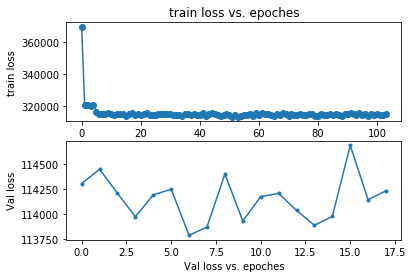

In [33]:
draw(train_loss_list, val_loss_list)

# 回归模型

### 回归模型一

In [34]:
batch_size2 = 1

In [35]:
# 定义LSTM的结构
class Change(nn.Module):
    def __init__(self):
        super(Change, self).__init__()
        self.score_fc = torch.nn.Conv2d(128, 3, kernel_size=1, stride=1)
        self.apply(weights_init)
        
    def forward(self, x):
        output = x    #[batch_size2, 128]
        output_expand = output.expand([batch_size2, batch_size2, 128])  #[batch_size2, batch_size2, 128]
        output_expand = output_expand.unsqueeze(0).permute(0, 3, 1, 2)  #[1,batch_size2,batch_size2,128]=>[1,128,batch_size2,batch_size2]
        score = self.score_fc(output_expand)
        score_out = F.normalize(score, p=2, dim = 1)
        score_out = score_out.squeeze(0) #[3, batch_size2, batch_size2]
        return score_out

### 回归模型二

In [144]:
# class Change(nn.Module):
#     def __init__(self):
#         super(Change, self).__init__()
#         #特征融合
#         self.score_fc = torch.nn.Conv1d(128, 2, kernel_size=1, stride=1)
#         self.apply(weights_init)

#     def forward(self, x):
#         output = x#[batch_size2, 128]
#         output = output.unsqueeze(2)
#         score = self.score_fc(output)
#         offset_pred = score.squeeze(2)
#         return offset_pred

#### 路径定义

In [36]:
save_the_second_model_path = './data/save/save_model2/' 
save_the_second_model_resualt_path = './data/save/save_model2/resualt.txt'

In [37]:
train_loss_2_list=[]
val_loss_2_list=[]

### 训练函数

In [147]:
# def train_for_Change_model_3(resualt_path, model_save_path, inital_epoch, batch_size2, lamba):
#     change_model = Change()
#     model = LSTM_CNN()
#     model.load_state_dict(torch.load('C:/Users/wuxun/Desktop/Data/save_model/new_model_for_1500/494_params.pkl'))
    
#     #冻结基础模型参数
#     model.eval()
#     for param in model.parameters():
#         param.requires_grad = False
    
#     #change_model.load_state_dict(torch.load('C:/Users/wuxun/Desktop/Data/save_model2/新训练的model1以后训练model2无alignment/batchsize_is_1_19.pkl'))
#     optimizer = optim.Adam(change_model.parameters(), lr = 0.001)
#     best_val_loss_2 = 1000000
#     print("train begin......")
#     for epoch in range(1000):
#         batch_train = batch_iter(x_batch_train, x_csv_train, y_csv_train, source_list_train, target_list_train, batch_size2)
#         count = 0
#         train_loss_sum = 0
#         begin_time = time.strftime("%Y-%m-%d %H:%M:%S", time.localtime())
#         for x_batch, x_csv, y_csv, source_time, target_time in batch_train:
#             if x_csv.shape[0]==batch_size2:
#                 count += 1
#                 x1 = Variable(torch.LongTensor(x_batch))
#                 x2 = Variable(torch.FloatTensor(np.array(x_csv)))
#                 source_time = Variable(torch.FloatTensor(np.array(source_time)))
#                 target_time = Variable(torch.FloatTensor(np.array(target_time)))
#                 pred = model(x1, x2)
#                 pred2 = change_model(pred)
            
#                 Loss = torch.abs(pred2 - target_time).mean()
                
#                 train_loss_sum += Loss
#                 optimizer.zero_grad()
#                 Loss.backward()
#                 optimizer.step()
                
#         current_time = time.strftime("%Y-%m-%d %H:%M:%S", time.localtime())        
#         line = begin_time+' | '+current_time+(' | Epoch: %3d | Loss: %.6f |' % (inital_epoch + epoch, train_loss_sum / (count)))
#         print(line)
#         write_resualt_file(resualt_path, line)
#         train_loss_2_list.append(train_loss_sum / count)

#         if (epoch+1)%5==0:
#             print("进行验证.......")
#             begin_time = time.strftime("%Y-%m-%d %H:%M:%S", time.localtime())
#             batch_val = batch_iter(x_batch_val, x_csv_val, y_csv_val,source_list_val,target_list_val, batch_size2)
#             count = 0
#             val_loss_sum = 0
#             for x_batch, x_csv, y_csv, source_time, target_time in batch_val:
#                 if x_csv.shape[0]==batch_size2:
#                     count += 1
#                     x1 = Variable(torch.LongTensor(x_batch))
#                     x2 = Variable(torch.FloatTensor(np.array(x_csv)))
#                     source_time = Variable(torch.FloatTensor(np.array(source_time)))
#                     target_time = Variable(torch.FloatTensor(np.array(target_time)))
#                     pred = model(x1, x2)
#                     pred2 = change_model(pred)
                    
#                     Loss = torch.abs(pred2 - target_time).mean()

#                     val_loss_sum += Loss
#                     optimizer.zero_grad()
#                     Loss.backward()
#                     optimizer.step()
            
#             current_time = time.strftime("%Y-%m-%d %H:%M:%S", time.localtime()) 
#             line = begin_time+' | '+current_time+(' | Epoch: %3d | Loss: %.6f |' % (inital_epoch + epoch, val_loss_sum / (count)))
#             print(line)
#             write_resualt_file(resualt_path, line)
#             val_loss_2_list.append(val_loss_sum / count) 
#             #torch.save(change_model.state_dict(), model_save_path + 'batchsize_is_64_the_first_model_300_' + str(inital_epoch + epoch)+'.pkl')
#             if (val_loss_sum / count ) < best_val_loss_2:
#                 best_val_loss_2 = val_loss_sum / count
#                 print("model save!")

In [45]:
def train_2(resualt_path, model_save_path, EPOCH=500, inital_epoch=0, lamba=0.01, inital_model=None, inital_Change_model=None, inital_lr=0.01):
    change_model = Change()
    model = LSTM_CNN()
    model.cuda()
    change_model.cuda()
    epsilon = 1e-6
    if inital_model is not None:
        model.load_state_dict(torch.load(inital_model))
    #冻结基础模型参数
    model.eval()
    for param in model.parameters():
        param.requires_grad = False
        
    if inital_Change_model is not None:
        change_model.load_state_dict(torch.load(inital_Change_model))
    
    optimizer = optim.Adam(change_model.parameters(), lr = inital_lr)
    best_val_loss_2 = 1000000
    for epoch in range(EPOCH):
        batch_train = batch_iter(x_batch_train, x_csv_train, y_csv_train, source_list_train, target_list_train, distance_train_list,batch_size2)
        count = 0
        train_loss_sum = 0
        train_alignmentloss_sum = 0
        train_regloss_sum =0
        begin_time = time.strftime("%Y-%m-%d %H:%M:%S", time.localtime())
        for x_batch, x_csv, y_csv, source_time, target_time, distance in batch_train:
            if x_csv.shape[0]==batch_size2:
                count += 1
                x1 = Variable(torch.LongTensor(x_batch)).cuda()
                x2 = Variable(torch.FloatTensor(np.array(x_csv))).cuda()
                y = Variable(torch.FloatTensor(np.array(y_csv))).cuda()
                source_time = Variable(torch.FloatTensor(np.array(source_time))).cuda()
                target_time = Variable(torch.FloatTensor(np.array(target_time))).cuda()
                pred = model(x1, x2)
                score = change_model(pred)
                alignment_mat = score[0]
                l_mat = score[1]
                r_mat = score[2]

                I = torch.eye(batch_size2).cuda()
                allone = torch.ones(batch_size2, batch_size2).cuda()
                mask = allone - 2 * I

                l_reg = torch.mm(l_mat * I, torch.ones(batch_size2, 1).cuda())
                r_reg = torch.mm(r_mat * I, torch.ones(batch_size2, 1).cuda())
                offset_pred = torch.cat([l_reg, r_reg], 1)

                loss_mat = torch.log(allone + torch.exp(mask * score[0] + epsilon))
                para = I + 1.0 / batch_size2 * allone
                loss_mat = loss_mat * para
                loss_alignment = loss_mat.mean()
                loss_reg = torch.abs(offset_pred - target_time).mean()
                
                #最终的损失函数
                Loss = loss_reg * lamba + loss_alignment
                
                train_regloss_sum += loss_reg
                train_loss_sum += Loss
                train_alignmentloss_sum += loss_alignment
                optimizer.zero_grad()
                Loss.backward()
                #nn.utils.clip_grad_norm_(change_model.parameters(), max_norm=20, norm_type=2)
                optimizer.step()
                
        current_time = time.strftime("%Y-%m-%d %H:%M:%S", time.localtime())    
        line = begin_time+' | '+current_time+(' | Epoch: %3d | Loss: %.6f | loss_align: %.6f | loss_reg: %.6f' % (epoch, train_loss_sum / (count), train_alignmentloss_sum / (count), train_regloss_sum / (count)))
        print(line)
        adjust_learning_rate(optimizer = optimizer, inital_lr = inital_lr)
        write_resualt_file(resualt_path, line)
        train_loss_2_list.append(train_loss_sum / count)

        if (epoch + 1) % 5 == 0:
            print("进行验证.......")
            begin_time = time.strftime("%Y-%m-%d %H:%M:%S", time.localtime())
            batch_val = batch_iter(x_batch_val, x_csv_val, y_csv_val,source_list_val,target_list_val, distance_val_list, batch_size2)
            count = 0
            val_loss_sum = 0
            val_alignmentloss_sum =0
            val_regloss_sum =0
            for x_batch, x_csv, y_csv, source_time, target_time, distance in batch_val:
                if x_csv.shape[0]==batch_size2:
                    count += 1
                    x1 = Variable(torch.LongTensor(x_batch)).cuda()
                    x2 = Variable(torch.FloatTensor(np.array(x_csv))).cuda()
                    y = Variable(torch.FloatTensor(np.array(y_csv))).cuda()
                    source_time = Variable(torch.FloatTensor(np.array(source_time))).cuda()
                    target_time = Variable(torch.FloatTensor(np.array(target_time))).cuda()
                    pred = model(x1, x2)
                    score = change_model(pred)
                    
                    #特征变换
                    alignment_mat = score[0]
                    l_mat = score[1]
                    r_mat = score[2]

                    I = torch.eye(batch_size2).cuda()
                    allone = torch.ones(batch_size2, batch_size2).cuda()
                    mask = allone - 2 * I

                    l_reg = torch.mm(l_mat * I, torch.ones(batch_size2, 1).cuda())
                    r_reg = torch.mm(r_mat * I, torch.ones(batch_size2, 1).cuda())
                    offset_pred = torch.cat([l_reg, r_reg], 1)
                    loss_mat = torch.log(allone + torch.exp(mask * score[0] + epsilon))

                    para = I + 1.0 / batch_size2 * allone
                    loss_mat = loss_mat * para
                    loss_alignment = loss_mat.mean()
                    loss_reg = torch.abs(offset_pred - target_time).mean()
                    
                    #模型最终的loss
                    Loss = loss_reg * lamba + loss_alignment
                    
                    val_alignmentloss_sum += loss_alignment
                    val_regloss_sum += loss_reg
                    val_loss_sum += Loss
                    optimizer.zero_grad()
                    
                    Loss.backward()
                    #nn.utils.clip_grad_norm_(change_model.parameters(), max_norm=20, norm_type=2)
                    optimizer.step()
            
            current_time = time.strftime("%Y-%m-%d %H:%M:%S", time.localtime()) 
            line = begin_time+' | '+current_time+(' | Epoch: %3d | Loss: %.6f | loss_align: %.6f | loss_reg: %.6f' % (epoch, val_loss_sum / (count), val_alignmentloss_sum / (count), val_regloss_sum / (count)))
            print(line)
            write_resualt_file(resualt_path, line)
            val_loss_2_list.append(val_loss_sum / count) 
            torch.save(change_model.state_dict(), model_save_path + 'epoch_'+str(inital_epoch + epoch)+'.pkl')
            if (val_loss_sum / count ) < best_val_loss_2:
                best_val_loss_2 = val_loss_sum / count
                print("model save!")

### 训练回归模型

In [46]:
# train_for_Change_model_3(save_resualt_path2, save_path2, 0)

In [72]:
inital_model = './data/save/save_model/913_params.pkl'
inital_model2 = './data/save/save_model2/epoch_103.pkl'

In [50]:
train_2(save_the_second_model_resualt_path, save_the_second_model_path, 500, 29, 0.01, inital_model, inital_model2, 0.1)

2020-08-24 19:02:34 | 2020-08-24 19:02:44 | Epoch:   0 | Loss: 2.537623 | loss_align: 0.629878 | loss_reg: 190.773682
2020-08-24 19:02:44 | 2020-08-24 19:02:53 | Epoch:   1 | Loss: 2.537692 | loss_align: 0.629948 | loss_reg: 190.773865
2020-08-24 19:02:53 | 2020-08-24 19:03:02 | Epoch:   2 | Loss: 2.535734 | loss_align: 0.627993 | loss_reg: 190.773590
2020-08-24 19:03:02 | 2020-08-24 19:03:12 | Epoch:   3 | Loss: 2.534866 | loss_align: 0.627131 | loss_reg: 190.773483
2020-08-24 19:03:12 | 2020-08-24 19:03:21 | Epoch:   4 | Loss: 2.536228 | loss_align: 0.628485 | loss_reg: 190.774170
进行验证.......
2020-08-24 19:03:21 | 2020-08-24 19:03:24 | Epoch:   4 | Loss: 2.452267 | loss_align: 0.629951 | loss_reg: 182.231827
model save!
2020-08-24 19:03:25 | 2020-08-24 19:03:34 | Epoch:   5 | Loss: 2.537114 | loss_align: 0.629374 | loss_reg: 190.773682
2020-08-24 19:03:34 | 2020-08-24 19:03:44 | Epoch:   6 | Loss: 2.535552 | loss_align: 0.627811 | loss_reg: 190.774399
2020-08-24 19:03:44 | 2020-08-24

KeyboardInterrupt: 

### 绘制loss

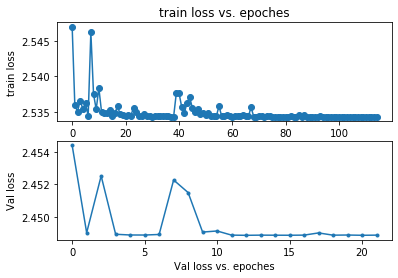

In [51]:
draw(train_loss_2_list, val_loss_2_list)

## 计算R@1

In [52]:
IoU_thresh = [0.1, 0.3, 0.5, 0.7]

In [53]:
def calculate_IoU(i0, i1):
    # calculate temporal intersection over union
    union = (min(i0[0], i1[0]), max(i0[1], i1[1]))
    inter = (max(i0[0], i1[0]), min(i0[1], i1[1]))
    iou = 1.0*(inter[1]-inter[0])/(union[1]-union[0])
    return iou

In [54]:
def compute_IoU_recall_top_n_forreg(iou_thresh, time_mat, time_pre_mat):#top
    correct_num = 0
    for i in range(time_mat.shape[0]):
        gt_start = time_mat[i][0]
        gt_end = time_mat[i][1]
        pred_start = time_pre_mat[i][0]
        pred_end = time_pre_mat[i][1]
        iou = calculate_IoU((gt_start, gt_end),(pred_start, pred_end))
        if iou>=iou_thresh:
            correct_num+=1
    return correct_num

In [68]:
#读取test集
# 读取test数据集
def get_test_dict_for_My_model(path, csv_path):
    words, word_to_id = read_vocab(vocab_dir)
    data_id = []
    csv=[]
    time_list=[]
    Max_len=-1
    count=0
    with open(path) as contents:
        for line in contents:
            count+=1
            List = line.split('#')
            video_name = List[0]
            time_length = float(List[1])
            foldtype = List[2]
            recipetype = List[3]
            target = List[4]
            
            #将句子转换为id表示：
            sentence = List[5].strip('\n').strip()
            sentence = re.split(r"[,| |.]",sentence)
            sentence_id = [word_to_id[x] for x in sentence if x in word_to_id]
            if len(sentence_id) > Max_len:
                Max_len = len(sentence_id)
            data_id.append(sentence_id)
            
            #寻找路径,先统一取0001
            dir_path = csv_path+'/'+foldtype+'/'+recipetype+'/'+video_name+'/0001/'
            name = os.listdir(dir_path)[0]
            dir_path = dir_path + name
            
            #读取csv文件
            my_file = Path(dir_path)
            if my_file.exists():
                frame_sum = pd.read_csv(dir_path, header=None)
            else:
                print("目录不存在！")
            
            #确定时间点，前帧后帧取pooling
            target = target.split('_')
            cur_start = float(target[0])
            cur_end = float(target[1])
            middle_time = (cur_start + cur_end)//2
            
            #中间帧
            target_frame_num = int(middle_time/time_length*500)
            target_middle_frame = frame_sum.loc[target_frame_num]
            
            csv.append([target_middle_frame])
            time_list.append([cur_start, cur_end])
            
    #将所有的句子pad为同一最大长度
    batch_data_id = np.array([line +[0]*(Max_len-len(line)) 
                                            for line in data_id])
    batch_seq = torch.LongTensor(batch_data_id)    
    print(len(batch_seq),len(csv),len(time_list))
    
    return batch_seq, csv, time_list

In [69]:
My_test_seq, My_test_csv, My_test_time_list = get_test_dict_for_My_model(test_path, csv_path)

132 132 132


In [73]:
middle_model = LSTM_CNN()
middle_model.load_state_dict(torch.load(inital_model))
My_model = Change()
My_model.load_state_dict(torch.load(inital_model2))
My_model.eval()
middle_model.eval()                                                                                                                                             

LSTM_CNN(
  (embedding): Embedding(5000, 64)
  (rnn): LSTM(64, 256, num_layers=2, bidirectional=True)
  (f1): Sequential(
    (0): Linear(in_features=512, out_features=128, bias=True)
    (1): Dropout(p=0.8, inplace=False)
    (2): ReLU()
  )
  (conv1): Conv1d(512, 256, kernel_size=(1,), stride=(1,))
  (conv2): Conv1d(256, 128, kernel_size=(1,), stride=(1,))
  (fc1): Linear(in_features=512, out_features=128, bias=True)
  (fc1_drop): Dropout(p=0.4, inplace=False)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (final_fc): Linear(in_features=256, out_features=128, bias=True)
)

In [80]:
list_1=[]
list_3=[]
list_5=[]
list_7=[]
for i in range(My_test_seq.shape[0]):
    x = Variable(torch.LongTensor(np.array(My_test_seq[i])))
    y = Variable(torch.FloatTensor(np.array(np.array(My_test_csv[i]))))
    My_time_mat = Variable(torch.FloatTensor(np.array(np.array(My_test_time_list[i]))))
    My_output1 = middle_model(x, y)
    score = My_model(My_output1)

    #特征变换
    alignment_mat = score[0]
    l_mat = score[1]
    r_mat = score[2]

    I = torch.eye(batch_size2)
    allone = torch.ones(batch_size2, batch_size2)
    mask = allone - 2 * I

    l_reg = torch.mm(l_mat * I, torch.ones(batch_size2, 1))
    r_reg = torch.mm(r_mat * I, torch.ones(batch_size2, 1))
    offset_pred = torch.cat([l_reg, r_reg], 1)
    for iou_thresh in IoU_thresh:
        corrnum = compute_IoU_recall_top_n_forreg(iou_thresh, My_time_mat[i], offset_pred)
        corr_avg = corrnum*1.0 / My_time_mat.shape[0] 
        if iou_thresh == 0.1:
            list_1.append(corr_avg)
        elif iou_thresh == 0.3:
            list_3.append(corr_avg)
        elif iou_thresh == 0.5:
            list_5.append(corr_avg)
        elif iou_thresh == 0.7:
            list_7.append(corr_avg)

RuntimeError: input must have 3 dimensions, got 2

In [ ]:
My_pred_time_mat = offset_pred
for iou_thresh in IoU_thresh:
    corrnum = compute_IoU_recall_top_n_forreg(iou_thresh, My_time_mat, My_pred_time_mat)
    corr_avg = corrnum*1.0 / My_time_mat.shape[0] 
    print("My_model: R@1 for iou_thresh: %.1f is : %.3f" % (iou_thresh, corr_avg))

## 计算偏移

In [64]:
def get_middle_time_list(time_mat):
    time_list = []
    for i in range(time_mat.shape[0]):
        begin = time_mat[i][0].detach().numpy()
        end = time_mat[i][1].detach().numpy()
        time_list.append((begin + end) / 2)
    return time_list

In [65]:
def calculate_offset(My_time_mat, My_pred_time_mat):
    '''
    返回平均偏移值与offset_list
    '''
    pred_list_time = get_middle_time_list(My_pred_time_mat)
    list_time = get_middle_time_list(My_time_mat)
    avg = 0.0
    offset_list = []
    for i in range(len(list_time)):
        offset = list_time[i] - pred_list_time[i]
        offset_list.append(offset)
        avg = avg + offset
    avg = avg / len(list_time)
    return avg, offset_list